<center><h1>scikit-image + ImgLib2 with ImgLyb</h1></center>

Let's start by importing the ImgLyb stuff:

In [1]:
# Set up ImgLyb.
import imglyb
from jnius import autoclass

What functions do we have?

In [2]:
list(filter(lambda func: not func.startswith('_'), dir(imglyb)))

['config',
 'imglib_ndarray',
 'print_function',
 'to_imglib',
 'to_imglib_argb',
 'to_numpy',
 'util']

In [3]:
# Define utility functions.
from matplotlib import pyplot as plt
def show(image):
    plt.imshow(image, interpolation='nearest')
    plt.show()

Let's open an image using scikit-image:

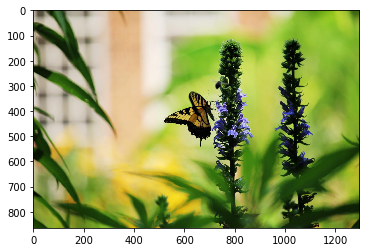

In [4]:
# Open an image.
from skimage import io
url = 'https://github.com/hanslovsky/imglyb-examples/raw/master/resources/butterfly_small.jpg'
img = io.imread(url)
show(img)

Next, we'll convert it from RGB to ARGB.
<br>ImgLib2 likes ARGB.

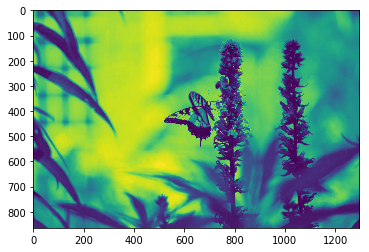

In [5]:
# Convert image to ARGB. (Is there a bug here?)
import numpy as np
argb = (
    np.left_shift(img[...,0], np.zeros(img.shape[:-1],dtype=np.uint32) + 16) + \
    np.left_shift(img[...,1], np.zeros(img.shape[:-1],dtype=np.uint32) + 8)  + \
    np.left_shift(img[...,2], np.zeros(img.shape[:-1],dtype=np.uint32) + 0) ) \
    .astype(np.int32)
show(argb)

A simple scikit-image filter:

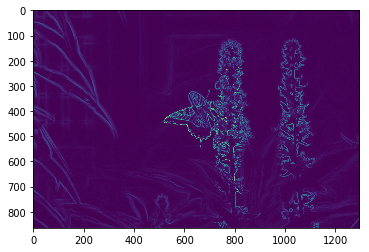

In [6]:
# Sobel filter.
from skimage import filters
avg = np.mean(img, axis=2)
gradient = filters.sobel(avg)
show(gradient)

Now finally, let's mix and match with ImgLib2.
<br>We'll call its Euclidean Distance Transform (EDT).

First, let's get some imports out of the way:

In [7]:
import multiprocessing
cpu_count = multiprocessing.cpu_count()

Executors = autoclass('java.util.concurrent.Executors')
DistanceTransform = autoclass('net.imglib2.algorithm.morphology.distance.DistanceTransform')
DISTANCE_TYPE = autoclass('net.imglib2.algorithm.morphology.distance.DistanceTransform$DISTANCE_TYPE')
Views = autoclass('net.imglib2.view.Views')

Now the fun part:

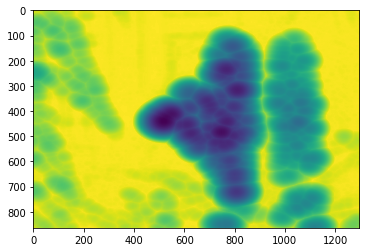

In [8]:
dt = np.zeros(avg.shape, dtype=avg.dtype)
DistanceTransform.transform( \
    Views.extendBorder(imglyb.to_imglib(-gradient)), \
    imglyb.to_imglib(dt), \
    DISTANCE_TYPE.EUCLIDIAN, \
    Executors.newFixedThreadPool(cpu_count), \
    cpu_count, 1e-2, 2e-2)
show(dt)